<a href="https://colab.research.google.com/github/Dererkzzz/ECE1512-2023F-ProjectRepo-Longqian-Zhang-Yuxuan-Liu/blob/main/ProjectA/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from IPython.display import Image, display
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
import numpy as np
from IPython.display import Image, display



builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

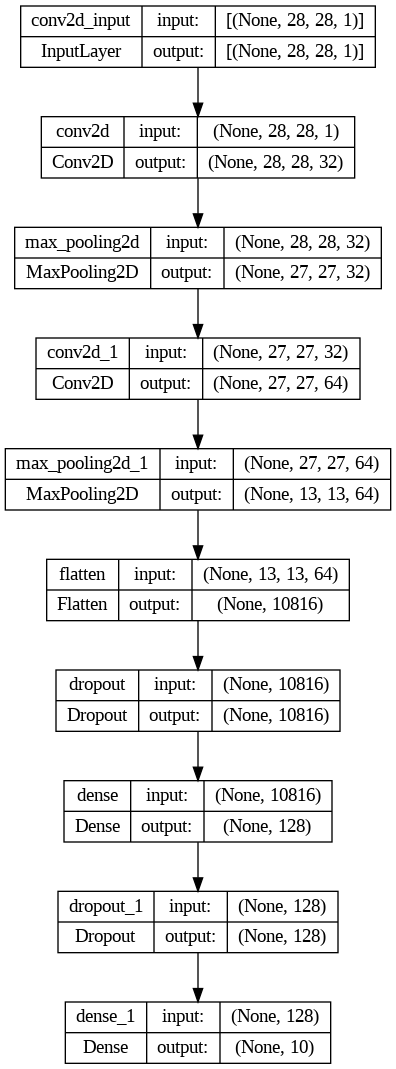

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 10816)             0

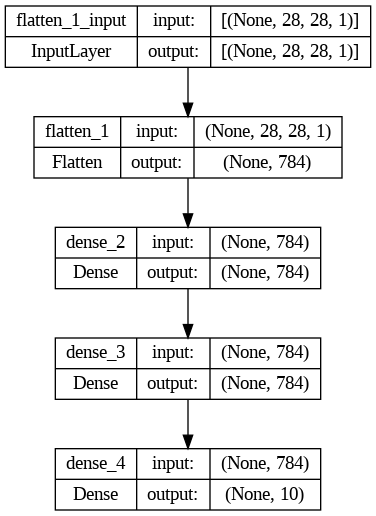

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1238730 (4.73 MB)
Trainable params: 1238730 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1),
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES),
    ])
# Using plot_model to generate a structural diagram of the model
file_path = 'cnn_model.png'
tf.keras.utils.plot_model(cnn_model, to_file=file_path, show_shapes=True, show_layer_names=True)
display(Image(filename=file_path))

cnn_model.summary()

# your code start from here for stpe 2


# Build fully connected student.
fc_model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES),
    ])
# generate a structural diagram of the model
file_path = 'fc_model.png'
tf.keras.utils.plot_model(fc_model, to_file=file_path, show_shapes=True, show_layer_names=True)
display(Image(filename=file_path))
fc_model.summary()

# Teacher loss function

In [4]:
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, subclass_logits)


  return cross_entropy_loss_value

# Student loss function

In [5]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True) # fc model

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False) # cnn_model
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, student_subclass_logits)

  return ALPHA * distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value

# Train and evaluation

In [6]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      correct_predictions = compute_num_correct(model, images, labels)
      num_correct += correct_predictions[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))



def student_train_and_evaluate(model, compute_student_loss, ALPHA, DISTILLATION_TEMPERATURE):
  """Perform training and evaluation for a student model.

  Args:
    model: Instance of tf.keras.Model.
    compute_student_loss: A function that computes the training loss given the
      images, and labels，ALPHA，Distillation_temperature
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        # your code start from here for step 4

        loss_value = compute_student_loss(images,labels, ALPHA, DISTILLATION_TEMPERATURE)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

# Training models

In [11]:
train_and_evaluate(cnn_model,compute_teacher_loss)

Epoch 1: 

Class_accuracy: 98.08%
Epoch 2: Class_accuracy: 98.74%
Epoch 3: Class_accuracy: 98.77%
Epoch 4: Class_accuracy: 98.97%
Epoch 5: Class_accuracy: 99.10%
Epoch 6: Class_accuracy: 99.04%
Epoch 7: Class_accuracy: 99.06%
Epoch 8: Class_accuracy: 99.23%
Epoch 9: Class_accuracy: 99.22%
Epoch 10: Class_accuracy: 99.22%
Epoch 11: Class_accuracy: 99.22%
Epoch 12: Class_accuracy: 99.27%


In [ ]:
# your code start from here for step 5

train_and_evaluate(cnn_model,compute_teacher_loss)

Epoch 1: Class_accuracy: 99.03%
Epoch 2: Class_accuracy: 99.01%
Epoch 3: Class_accuracy: 99.03%
Epoch 4: Class_accuracy: 99.09%
Epoch 5: Class_accuracy: 99.14%
Epoch 6: Class_accuracy: 99.19%
Epoch 7: Class_accuracy: 99.12%
Epoch 8: Class_accuracy: 99.24%
Epoch 9: Class_accuracy: 99.24%
Epoch 10: Class_accuracy: 99.34%
Epoch 11: Class_accuracy: 99.27%
Epoch 12: Class_accuracy: 99.34%


In [ ]:
student_train_and_evaluate(fc_model,compute_student_loss, 0.7, 8)

Epoch 1: Class_accuracy: 96.67%
Epoch 2: Class_accuracy: 97.67%
Epoch 3: Class_accuracy: 98.15%
Epoch 4: Class_accuracy: 98.38%
Epoch 5: Class_accuracy: 98.39%
Epoch 6: Class_accuracy: 98.50%
Epoch 7: Class_accuracy: 98.66%
Epoch 8: Class_accuracy: 98.63%
Epoch 9: Class_accuracy: 98.66%
Epoch 10: Class_accuracy: 98.73%
Epoch 11: Class_accuracy: 98.78%
Epoch 12: Class_accuracy: 98.70%


# Test accuracy vs. tempreture curve

In [ ]:
# Define a list of temperatures and alpha
temperatures = [1, 2, 4, 16, 32, 64]
alpha = 0.5
test_accuracy = []

# Define the student model architecture
# Function to train and evaluate the student model


# Iterate over temperatures and evaluate the model
for i, temp in enumerate(temperatures):

    student_train_and_evaluate(fc_model, compute_student_loss, alpha, temp)

    num_correct = 0
    num_total = builder.info.splits['test'].num_examples

    print('Distillation_temperature:', temp)

    for images, labels in mnist_test:
        num_correct += compute_num_correct(fc_model, images, labels)[0]

    class_accuracy = (num_correct / num_total) * 100
    print("Class accuracy: {:.2f}%".format(class_accuracy),'\n')
    test_accuracy.append(class_accuracy)


Epoch 1: Class_accuracy: 98.30%
Epoch 2: Class_accuracy: 98.41%
Epoch 3: Class_accuracy: 98.60%
Epoch 4: Class_accuracy: 98.64%
Epoch 5: Class_accuracy: 98.77%
Epoch 6: Class_accuracy: 98.52%
Epoch 7: Class_accuracy: 98.67%
Epoch 8: Class_accuracy: 98.69%
Epoch 9: Class_accuracy: 98.52%
Epoch 10: Class_accuracy: 98.61%
Epoch 11: Class_accuracy: 98.72%
Epoch 12: Class_accuracy: 98.66%
For Distillation temperature: 1
Class accuracy: 98.66% 

Epoch 1: Class_accuracy: 98.92%
Epoch 2: Class_accuracy: 98.82%
Epoch 3: Class_accuracy: 98.88%
Epoch 4: Class_accuracy: 98.76%
Epoch 5: Class_accuracy: 98.92%
Epoch 6: Class_accuracy: 98.94%
Epoch 7: Class_accuracy: 98.99%
Epoch 8: Class_accuracy: 98.82%
Epoch 9: Class_accuracy: 98.90%
Epoch 10: Class_accuracy: 98.96%
Epoch 11: Class_accuracy: 98.95%
Epoch 12: Class_accuracy: 98.95%
For Distillation temperature: 2
Class accuracy: 98.95% 

Epoch 1: Class_accuracy: 98.97%
Epoch 2: Class_accuracy: 98.95%
Epoch 3: Class_accuracy: 98.95%
Epoch 4: Class_a

Plot graph

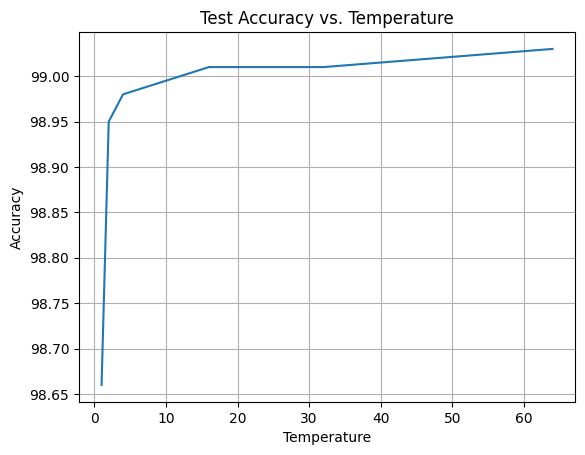

In [ ]:
# import matplotlib.pyplot as plt

# # Plotting accuracy vs temperature
# plt.plot(temperatures, test_accuracy)
# plt.title('Test Accuracy vs. Temperature')
# plt.xlabel('Temperature')
# plt.ylabel('Accuracy')
# plt.grid(True)  # Add grid lines for better visualization
# plt.show()

import matplotlib.pyplot as plt

# Set up the figure and axis
fig, ax = plt.subplots()

# Plotting the data
ax.plot(temperatures, test_accuracy)

# Setting the title and labels
ax.set_title('Test Accuracy vs. Temperature')
ax.set_xlabel('Temperature')
ax.set_ylabel('Accuracy')

# Displaying grid lines
ax.grid(True)

# Displaying the plot
plt.show()

# Train student from scratch

In [ ]:

# your code start from here for step 7

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model(images, training=True)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, student_subclass_logits)

  return cross_entropy_loss


train_and_evaluate(fc_model, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.80%
Epoch 2: Class_accuracy: 97.21%
Epoch 3: Class_accuracy: 97.68%
Epoch 4: Class_accuracy: 97.80%
Epoch 5: Class_accuracy: 97.52%
Epoch 6: Class_accuracy: 97.76%
Epoch 7: Class_accuracy: 98.37%
Epoch 8: Class_accuracy: 97.98%
Epoch 9: Class_accuracy: 97.26%
Epoch 10: Class_accuracy: 98.21%
Epoch 11: Class_accuracy: 97.50%
Epoch 12: Class_accuracy: 98.14%


# Comparing the teacher and student model (number of of parameters and FLOPs)

In [ ]:
def calcuate_flops(model):
    # Define a forward pass as a tf.function
    @tf.function(input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
    def forward_pass(inputs):
        return model(inputs)

    # Profile the forward pass to calculate FLOPs
    graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

    # Calculate FLOPs (floating-point operations)
    flops = graph_info.total_float_ops // 2  # Divide by 2 to account for multiply and accumulate as two ops

    # Calculate the number of model parameters
    total_params = model.count_params()

    return flops, total_params


In [ ]:
#Calculating FLOPs and no. of parameters for the teacher model

flops_teacher, teacher_totalParams = calcuate_flops(cnn_model)
print('Flops for teacher model: {:,}'.format(flops_teacher))
print('Total Parameters for teacher model: {:,}'.format(teacher_totalParams))

Flops for teacher model: 15,152,677
Total Parameters for teacher model: 1,404,682


In [ ]:
#Calculating FLOPs and no. of parameters for the student model

flops_student, student_totalParams = calcuate_flops(fc_model)
print('Flops for student model: {:,}'.format(flops_student))
print('Total Parameters for student model: {:,}'.format(student_totalParams))

Flops for student model: 1,237,941
Total Parameters for student model: 1,238,730


question 13 apply lime

In [ ]:
!pip install lime

import tensorflow as tf
import tensorflow_datasets as tfds
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Define the number of classes for the MNIST dataset
NUM_CLASSES = 10


explainer = lime_image.LimeImageExplainer()

# Function to preprocess the data
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

# Load and preprocess the MNIST dataset
BATCH_SIZE = 32

mnist_test = tfds.load('mnist', split='test', as_supervised=True)
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Get a single image and its label from the test dataset
for images, labels in mnist_test.take(1):
    test_image = images[0].numpy()  # Take the first image from the batch
    test_label = labels[0].numpy()  # Take the label of the first image

# Function to make predictions for LIME
def model_predict(image_batch):
    image_batch = tf.expand_dims(image_batch, axis=0) if image_batch.ndim == 3 else image_batch
    predictions = cnn_model.predict(image_batch)
    return predictions

# Explain the prediction on the test image using LIME
explanation = explainer.explain_instance(test_image.astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)

# Get image and mask for the top prediction
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

# Display the image and the mask
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"True label: {test_label}")
plt.show()

# Implementing the state-of-the-art KD algorithm--Improved Knowledge Distillation via Teacher Assistant

In [ ]:
# your code start from here for step 12

# Build a Teacher Assistant (TA) network with one convolutional layer and two fully connected layers.
ta_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(14, kernel_size=3, strides=1, padding='same', activation="relu",
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES),
    ])

file_path = 'ta_model.png'
tf.keras.utils.plot_model(ta_model, to_file=file_path, show_shapes=True, show_layer_names=True)
display(Image(filename=file_path))
ta_model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 14)        140       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 27, 27, 14)        0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 10206)             0         
                                                                 
 dense_26 (Dense)            (None, 128)               1306496   
                                                                 
 dense_27 (Dense)            (None, 10)                1290      
                                                                 
Total params: 1307926 (4.99 MB)
Trainable params: 1307926 (4.99 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [ ]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):

  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_ta_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):

  ta_subclass_logits = ta_model(images, training=True)

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, ta_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, ta_subclass_logits)

  return ALPHA * distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value

In [ ]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(ta_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):

  soft_targets = tf.nn.softmax(ta_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):

  student_subclass_logits = fc_model(images, training=True)

  ta_subclass_logits = ta_model(images, training=False)
  distillation_loss_value = distillation_loss(ta_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, student_subclass_logits)

  return ALPHA * distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value


In [ ]:
def compute_num_correct(model, images, labels):
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

def ta_train_and_evaluate(model, compute_loss_fn, ALPHA, DISTILLATION_TEMPERATURE):

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels, ALPHA, DISTILLATION_TEMPERATURE)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:

      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


In [ ]:
train_and_evaluate(cnn_model,compute_teacher_loss)

Epoch 1: Class_accuracy: 99.26%
Epoch 2: Class_accuracy: 99.24%
Epoch 3: Class_accuracy: 99.19%
Epoch 4: Class_accuracy: 99.28%
Epoch 5: Class_accuracy: 99.35%
Epoch 6: Class_accuracy: 99.34%
Epoch 7: Class_accuracy: 99.26%
Epoch 8: Class_accuracy: 99.24%
Epoch 9: Class_accuracy: 99.36%
Epoch 10: Class_accuracy: 99.26%
Epoch 11: Class_accuracy: 99.26%
Epoch 12: Class_accuracy: 99.40%


In [ ]:
ta_train_and_evaluate(ta_model,compute_ta_loss, 0.7, 8)

Epoch 1: Class_accuracy: 96.03%
Epoch 2: Class_accuracy: 97.55%
Epoch 3: Class_accuracy: 98.10%
Epoch 4: Class_accuracy: 98.44%
Epoch 5: Class_accuracy: 98.58%
Epoch 6: Class_accuracy: 98.72%
Epoch 7: Class_accuracy: 98.78%
Epoch 8: Class_accuracy: 98.95%
Epoch 9: Class_accuracy: 98.89%
Epoch 10: Class_accuracy: 98.97%
Epoch 11: Class_accuracy: 99.01%
Epoch 12: Class_accuracy: 98.98%


In [ ]:
student_train_and_evaluate(fc_model, compute_student_loss, 0.7, 8)

Epoch 1: Class_accuracy: 98.80%
Epoch 2: Class_accuracy: 98.83%
Epoch 3: Class_accuracy: 98.86%
Epoch 4: Class_accuracy: 98.88%
Epoch 5: Class_accuracy: 98.84%
Epoch 6: Class_accuracy: 98.79%
Epoch 7: Class_accuracy: 98.78%
Epoch 8: Class_accuracy: 98.83%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.90%
Epoch 11: Class_accuracy: 98.84%
Epoch 12: Class_accuracy: 98.90%


### FitNet

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds


builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

build model

In [ ]:
# teacher model
teacher_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation="relu",
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1),
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES),
    ])
# Extract the output of the hint layer
hint_layer_index = 6
hint_layer = teacher_model.layers[hint_layer_index]

# Creates a new model that accepts inputs and outputs the activation of the hint layer
hint_model = tf.keras.Model(inputs=teacher_model.input, outputs=hint_layer.output)

teacher_hint_model = tf.keras.Sequential([ hint_model,tf.keras.layers.Dense(units=10, activation='linear')])


# student model
student_model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES),
    ])

# extract guide layer
guided_layer = student_model.layers[2]
guided_model = tf.keras.Model(inputs=student_model.input, outputs=guided_layer.output)

student_hint_model = tf.keras.Sequential([ guided_model,tf.keras.layers.Dense(units=10, activation='linear')])

In [ ]:
# Function to compute the fitnet loss
def compute_fitnet_loss_for_batch(batch_data):
    images, _ = batch_data
    teacher_activations = teacher_hint_model(images)
    student_activations = student_hint_model(images)
    return compute_distillation_loss(teacher_activations, student_activations)

# Function to compute the loss between teacher's activations and student's activations
def compute_distillation_loss(teacher_activations, student_activations):
    return tf.reduce_mean(tf.square(teacher_activations - student_activations))

In [ ]:
# Function to compute the overall student loss including distillation and cross-entropy loss
def compute_combined_student_loss(images, labels, teacher_hint_model, student_hint_model, ALPHA=0.9):
    student_logits = student_model(images, training=True)
    teacher_logits = teacher_model(images, training=False)

    teacher_activations = teacher_hint_model(images)
    student_activations = student_hint_model(images)

    distillation_loss = compute_distillation_loss(teacher_activations, student_activations)

    # Compute cross-entropy loss with hard targets
    cross_entropy_loss_fn = tf.keras.losses.CategoricalCrossentropy(axis=-1)
    cross_entropy_loss = cross_entropy_loss_fn(labels, tf.nn.softmax(student_logits, axis=-1))

    return ALPHA * distillation_loss + (1 - ALPHA) * cross_entropy_loss


Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_22 (Functional)       (None, 784)               1230880   
                                                                 
 dense_98 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1238730 (4.73 MB)
Trainable params: 1238730 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
@tf.function
def compute_correct_predictions(model, images, labels):
    """Compute number of correctly classified images in a batch."""
    logits = model(images, training=False)
    predicted_labels = tf.argmax(logits, -1)
    true_labels = tf.argmax(labels, -1)

    correct_predictions = tf.reduce_sum(tf.cast(tf.math.equal(predicted_labels, true_labels), tf.float32))
    return correct_predictions, predicted_labels, true_labels

In [ ]:
def train_and_evaluate_teacher_student(teacher, student, teacher_hint_model, student_hint_model, loss_fn):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f'Epoch {epoch}: ', end='')
        for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                loss_value = compute_combined_student_loss(images, labels, teacher_hint_model, student_hint_model)
            gradients = tape.gradient(loss_value, student.trainable_variables)
            optimizer.apply_gradients(zip(gradients, student.trainable_variables))

        # Evaluate the model's performance
        total_correct = 0
        total_samples = builder.info.splits['test'].num_examples
        for images, labels in mnist_test:
            correct_preds = compute_correct_predictions(student, images, labels)[0]
            total_correct += correct_preds

        accuracy = (total_correct / total_samples) * 100
        print(f"Classification Accuracy: {accuracy:.2f}%")

In [ ]:
train_and_evaluate_teacher_student(teacher_model,student_model,teacher_hint_model,student_hint_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.63%
Epoch 2: Class_accuracy: 97.84%
Epoch 3: Class_accuracy: 98.32%
Epoch 4: Class_accuracy: 98.65%
Epoch 5: Class_accuracy: 98.55%
Epoch 6: Class_accuracy: 98.74%
Epoch 7: Class_accuracy: 98.84%
Epoch 8: Class_accuracy: 98.83%
Epoch 9: Class_accuracy: 98.94%
Epoch 10: Class_accuracy: 98.86%
Epoch 11: Class_accuracy: 98.81%
Epoch 12: Class_accuracy: 98.83%


# XAI method to explain models

In [ ]:
# your code start from here for step 13
